# Import Libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder as le
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import plotly.express as px
from ipywidgets import interact, widgets
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.inspection import permutation_importance
import shap


# Data

In [8]:
rs=123

In [9]:
data=pd.read_csv(r"C:\Users\HP\Desktop\Online Courses\IBM Machine Learning Engineer\2. Classification\All data\heartattack.csv", na_values='?')

# Exploring and Cleaning Data

In [10]:
# columns
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num       '],
      dtype='object')

In [11]:
# general info of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         294 non-null    int64  
 1   sex         294 non-null    int64  
 2   cp          294 non-null    int64  
 3   trestbps    293 non-null    float64
 4   chol        271 non-null    float64
 5   fbs         286 non-null    float64
 6   restecg     293 non-null    float64
 7   thalach     293 non-null    float64
 8   exang       293 non-null    float64
 9   oldpeak     294 non-null    float64
 10  slope       104 non-null    float64
 11  ca          3 non-null      float64
 12  thal        28 non-null     float64
 13  num         294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


In [12]:
# Renaming target variable
data = data.rename(columns={'num       ': 'heart_attack'})

In [13]:
# summary of data types
data.dtypes.value_counts()

float64    10
int64       4
Name: count, dtype: int64

In [14]:
# missing values
data.isnull().sum()

age               0
sex               0
cp                0
trestbps          1
chol             23
fbs               8
restecg           1
thalach           1
exang             1
oldpeak           0
slope           190
ca              291
thal            266
heart_attack      0
dtype: int64

In [15]:
# To keep the cleaning process simple, we’ll remove:
# the columns with many missing values, which are slope, ca, thal.
# the rows with missing values.

data = data.drop(['slope', 'ca', 'thal'], axis=1)

data = data.dropna().copy()

In [16]:
data.isnull().sum()

age             0
sex             0
cp              0
trestbps        0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
heart_attack    0
dtype: int64

In [ ]:
feature_labels={
'age': 'age',
'sex': 'sex',
'cp_1': 'Chest pain: typical angina',
'cp_2': 'chest pain: atypical angina',
'cp_3': 'chest pain: non-anginal pain',
'cp_4': 'chest pain: asymptomatic',
'trestbps' : 'resting blood pressure',
'chol' : 'serum cholesterol',
'fbs': 'fasting blood sugar > 120 mg/dl)',
'restecg_0': 'resting electrocardiographic results:normal',
'restecg_1.0': 'resting electrocardiographic results:having ST-T wave abnormality',
'restecg_2': "resting electrocardiographic results:showing probable or definite left ventricular hypertrophy by Estes’ criteria",
'thalach': 'maximum heart rate achieved',
'exang': 'exercise-induced angina',
'oldpeak': 'ST depression induced by exercise relative to rest'
}


## Create a function to group variable names according the type of data; binary, categorical and continous

In [17]:
def group_variables_types(data):
    numeric_columns = list(data.select_dtypes(include=[np.number]).columns)
    binary_variables=[]
    categorical_variables=[]
    continous_variables=[]
    for i in numeric_columns:
        unique_counts=len(data[i].unique())
        if unique_counts==2:
            binary_variables.append(i)
        elif unique_counts in range(3,10):
            categorical_variables.append(i)
        else:
            continous_variables.append(i)
    print('binary_variables= {}'.format(binary_variables))
    print('categorical_variables= {}'.format(categorical_variables))
    print('continous_variables= {}'.format(continous_variables))

In [18]:
binary_variables= ['sex', 'fbs', 'exang', 'heart_attack']
categorical_variables= ['cp', 'restecg']
continous_variables= ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

## Outliers

In [19]:
# using z-score

treshold=3
for column in continous_variables:
    # Calculate the z-scores
    z_scores = stats.zscore(data[column])
    
    # Find the rows where z-scores are greater than treshold
    outliers = np.abs(z_scores) > treshold
    
    # Replace outliers with the mean value of the column
    mean_value = data[column].mean()
    data.loc[outliers, column] = mean_value
for column in categorical_variables:
    # Calculate the z-scores
    z_scores = stats.zscore(data[column])
    
    # Find the rows where z-scores are greater than treshold
    outliers = np.abs(z_scores) > treshold
    
    # Replace outliers with the mean value of the column
    median_value = data[column].median()
    data.loc[outliers, column] = median_value

# # Now, data contains the data with outliers replaced by the mean value for each numeric column
data

C:\Users\HP\AppData\Local\Temp\ipykernel_11936\644152527.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '47.770114942528735' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[outliers, column] = mean_value


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,heart_attack
0,28.0,1,2,130.0,132.0,0.0,0.0,185.0,0.0,0.0,0
1,29.0,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,0
3,30.0,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,0
4,31.0,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,0
5,32.0,0,2,105.0,198.0,0.0,0.0,165.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
289,52.0,1,4,160.0,331.0,0.0,0.0,94.0,1.0,2.5,1
290,54.0,0,3,130.0,294.0,0.0,1.0,100.0,1.0,0.0,1
291,56.0,1,4,155.0,342.0,1.0,0.0,150.0,1.0,3.0,1
292,58.0,0,2,180.0,393.0,0.0,0.0,110.0,1.0,1.0,1


In [20]:
# using z-score

treshold=3
outlier_columns=[]
for column in data.columns:
    # Calculate the z-scores
    z_scores = stats.zscore(data[column])
    
    # Find the rows where z-scores are greater than treshold
    outliers = np.abs(z_scores) > treshold
data[outliers]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,heart_attack


In [21]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'heart_attack'],
      dtype='object')

In [22]:
# age: age in years
# sex: sex (1 = male; 0 = female)
# cp: chest pain type
# – 1: typical angina
# – 2: atypical angina
# – 3: non-anginal pain
# – 4: asymptomatic
# trestbps: resting blood pressure (in mm Hg on admission to the hospital)
# chol: serum cholesterol in mg/dl
# fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
# restecg: resting electrocardiographic results
# – 0: normal
# – 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
# – 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
# thalach: maximum heart rate achieved
# exang: exercise-induced angina (1 = yes; 0 = no)
# oldpeak: ST depression induced by exercise relative to rest


## Transform the Categorical Variables: Creating Dummy Variables

In [23]:
### Among the five categorical variables, sex, fbs, and exang only have two levels of 0 and 1, 
# so they are already in the dummy variable format. But we still need to convert cp and restecg 
# into dummy variables

print(data['cp'].value_counts(dropna=False))

print(data['restecg'].value_counts(dropna=False))

cp
4    113
2     92
3     46
1     10
Name: count, dtype: int64
restecg
0.0    214
1.0     47
Name: count, dtype: int64


In [24]:
data = pd.get_dummies(data, columns=['cp', 'restecg'], drop_first=True)
data

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,heart_attack,cp_2,cp_3,cp_4,restecg_1.0
0,28.0,1,130.0,132.0,0.0,185.0,0.0,0.0,0,True,False,False,False
1,29.0,1,120.0,243.0,0.0,160.0,0.0,0.0,0,True,False,False,False
3,30.0,0,170.0,237.0,0.0,170.0,0.0,0.0,0,False,False,False,True
4,31.0,0,100.0,219.0,0.0,150.0,0.0,0.0,0,True,False,False,True
5,32.0,0,105.0,198.0,0.0,165.0,0.0,0.0,0,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,52.0,1,160.0,331.0,0.0,94.0,1.0,2.5,1,False,False,True,False
290,54.0,0,130.0,294.0,0.0,100.0,1.0,0.0,1,False,True,False,True
291,56.0,1,155.0,342.0,1.0,150.0,1.0,3.0,1,False,False,True,False
292,58.0,0,180.0,393.0,0.0,110.0,1.0,1.0,1,True,False,False,False


In [25]:
# we can print out the numeric columns and categorical columns as numeric_cols and cat_cols below.

numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_cols = list(set(data.columns) - set(numeric_cols) - {'target'})
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
['cp_2', 'cp_3', 'cp_4', 'exang', 'fbs', 'heart_attack', 'restecg_1.0', 'sex']


## Transform the Numerical Variables: Scaling

In [26]:
scaler = StandardScaler()
for i in numeric_cols:
    data[i]=scaler.fit_transform(data[[i]])

## Defining Target and Features

In [27]:
y=data['heart_attack']
X=data.drop(columns='heart_attack')

## Split Training and Test Datasets

when the dataset is imbalanced, it’s good practice to do stratified sampling. In this way, both the training and test datasets will have similar portions of the target classes as the complete dataset.

In [28]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state =rs)

In [29]:
X_train.shape, X_test.shape

((208, 12), (53, 12))

## Define Logistic Regression Model

In [30]:
model_lr = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
model_lr.fit(X_train,y_train)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

## Evaluating Model 

In [31]:
predictions_lr=model_lr.predict(X_test)

In [32]:
def evaluations(y, yhat):
    accuracy = accuracy_score(y_test, predictions_lr)
    precision, recall, f_beta, _ = precision_recall_fscore_support(y_test, predictions_lr)
    print('Accuracy Score = {}'.format(accuracy))
    print('Precision Score = {}'.format(precision))
    print('Recall Score = {}'.format(recall))
    print('f_beta Score = {}'.format(f_beta))
evaluations(y_test, predictions_lr)

Accuracy Score = 0.7735849056603774
Precision Score = [0.81818182 0.7       ]
Recall Score = [0.81818182 0.7       ]
f_beta Score = [0.81818182 0.7       ]


In [33]:
cm_lr=confusion_matrix(y_test, predictions_lr, normalize='true')

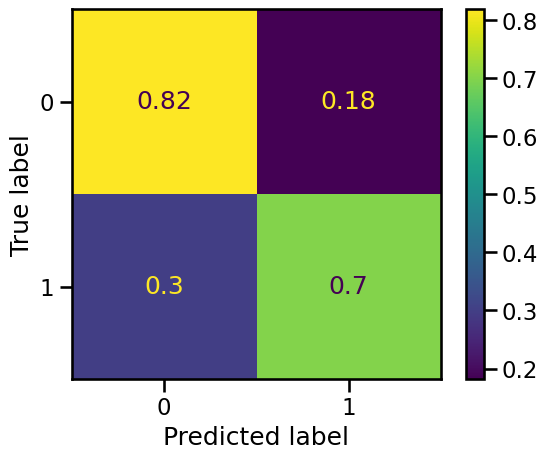

In [34]:
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,display_labels=model_lr.classes_)
disp.plot()
plt.show()

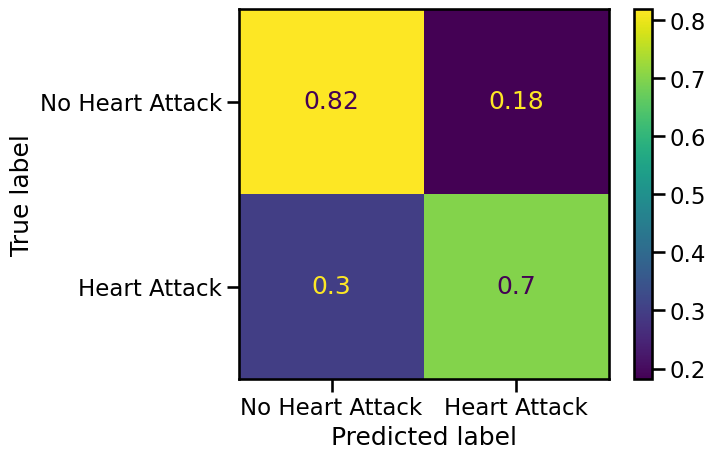

In [35]:
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,display_labels=['No Heart Attack','Heart Attack'])
disp.plot()
plt.show()

In [36]:
print(classification_report(y_test, predictions_lr))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        33
           1       0.70      0.70      0.70        20

    accuracy                           0.77        53
   macro avg       0.76      0.76      0.76        53
weighted avg       0.77      0.77      0.77        53



## Interpretation of Results

In [37]:
model_lr.coef_

array([[ 1.27306578e-01,  1.54873755e+00, -8.88643956e-02,
        -2.37434112e-02,  5.02227488e-01, -1.10047204e-01,
         1.06911709e+00,  1.04069992e+00, -2.22423788e+00,
        -7.53609922e-01,  5.64481771e-01,  2.07662446e-04]])

In [38]:

# create a data frame with the feature names and coefficients
coef_df = pd.DataFrame(zip(X.columns, model_lr.coef_[0]), columns=['Variable', 'Coefficient'])
# print the data frame
print(coef_df)


       Variable  Coefficient
0           age     0.127307
1           sex     1.548738
2      trestbps    -0.088864
3          chol    -0.023743
4           fbs     0.502227
5       thalach    -0.110047
6         exang     1.069117
7       oldpeak     1.040700
8          cp_2    -2.224238
9          cp_3    -0.753610
10         cp_4     0.564482
11  restecg_1.0     0.000208


## KNN MODEL

In [39]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X_train, y_train)
predictions_knn = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, predictions_knn))
print('Accuracy score: ', round(accuracy_score(y_test, predictions_knn), 2))
print('F1 Score: ', round(f1_score(y_test, predictions_knn), 2))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79        33
           1       0.65      0.75      0.70        20

    accuracy                           0.75        53
   macro avg       0.74      0.75      0.75        53
weighted avg       0.76      0.75      0.76        53

Accuracy score:  0.75
F1 Score:  0.7


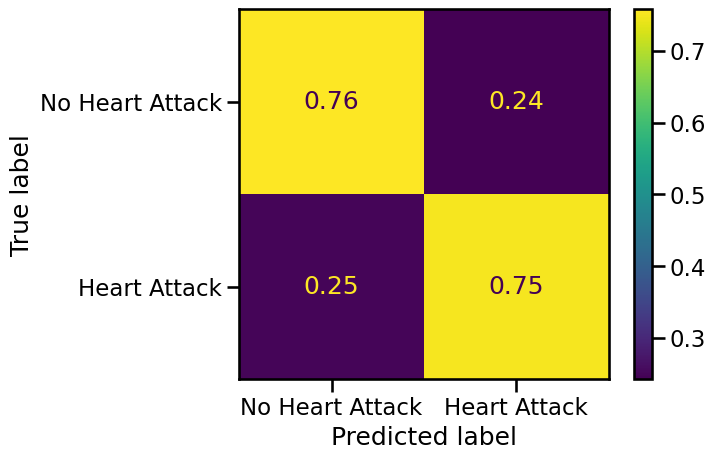

In [40]:
cm_knn=confusion_matrix(y_test, predictions_knn, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,display_labels=['No Heart Attack','Heart Attack'])
disp.plot()
plt.show()

## Choosing Optimal k

In [41]:
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1920x1440 with 0 Axes>

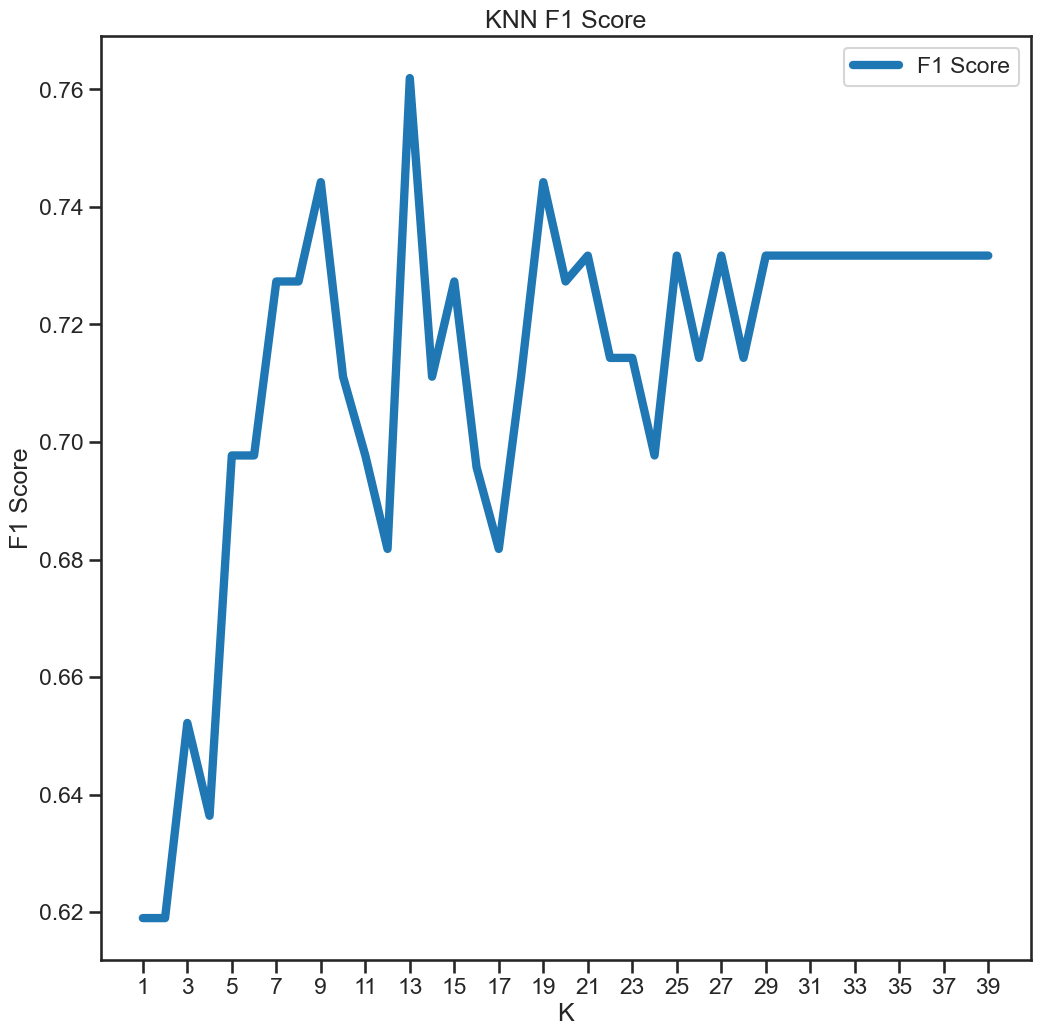

In [42]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 1920x1440 with 0 Axes>

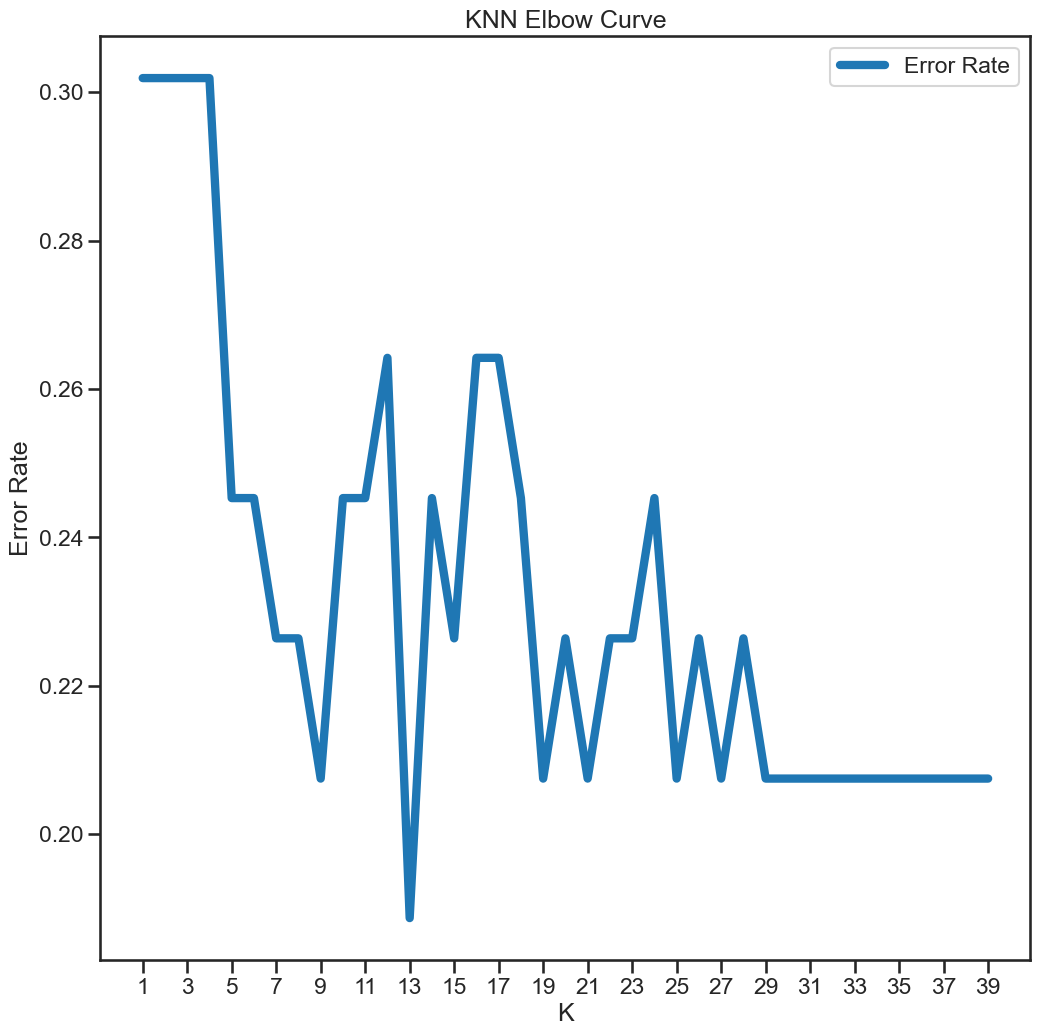

In [43]:
# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

## Support Vector Machines (SVM)

In [44]:
model_svm = SVC(kernel='linear', gamma=0.1, C=1)
model_svm.fit(X_train, y_train)


SVC(C=1, gamma=0.1, kernel='linear')

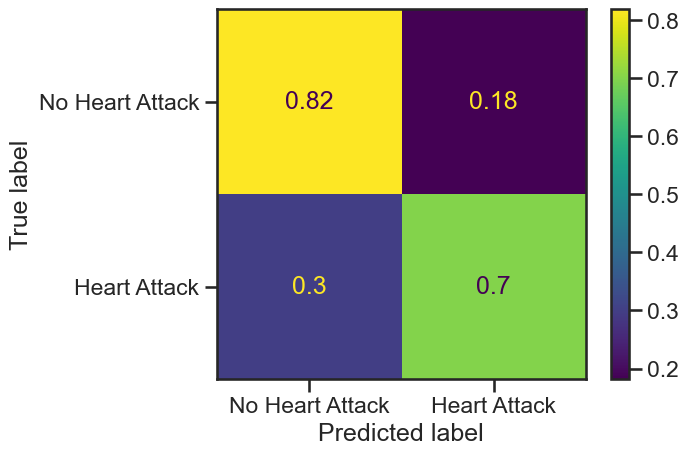

In [45]:

predictions_svm = model_svm.predict(X_test)

cm_svm=confusion_matrix(y_test, predictions_svm, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm,display_labels=['No Heart Attack','Heart Attack'])
disp.plot()
plt.show()

In [46]:
# Finding the best hyperparameters
params_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','linear']
}

search_smv = GridSearchCV(
    estimator=SVC(),
    param_grid=params_svm,
    cv=5,
    n_jobs=5,
    verbose=1
)

model_svm=search_smv.fit(X_train, y_train)
print(model_svm.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


## Decision Tree

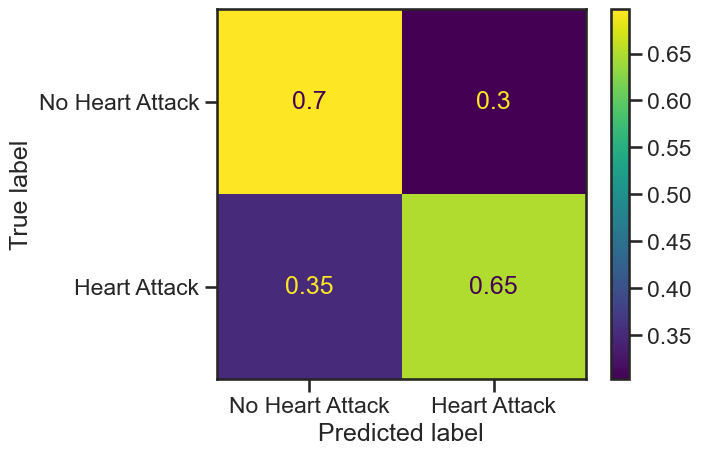

In [47]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt = model_dt.fit(X_train, y_train)

predictions_dt=model_dt.predict(X_test)

cm_dt=confusion_matrix(y_test, predictions_dt, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt,display_labels=['No Heart Attack','Heart Attack'])
disp.plot()
plt.show()

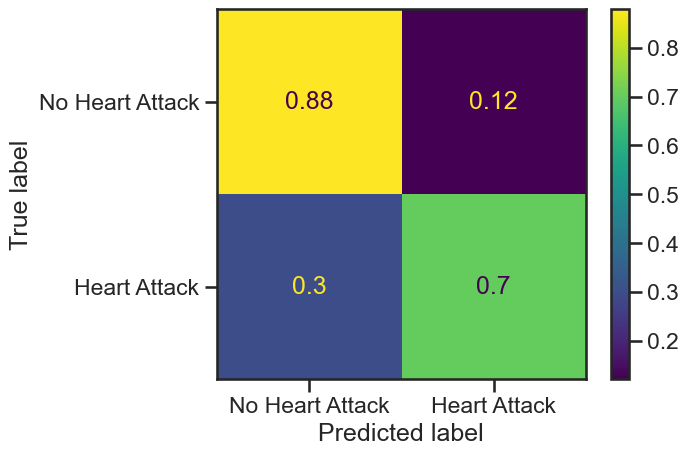

In [48]:

param_grid = {'max_depth':range(1, model_dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(model_dt.feature_importances_)+1)}

model_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

model_dt = model_dt.fit(X_train, y_train)

# model_dt.best_estimator_.tree_.node_count, model_dt.best_estimator_.tree_.max_depth

predictions_dt=model_dt.predict(X_test)

cm_dt=confusion_matrix(y_test, predictions_dt, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt,display_labels=['No Heart Attack','Heart Attack'])
disp.plot()
plt.show()

## Random Forest

In [49]:
n_estimators=20
M_features=X.shape[1]
max_features=round(np.sqrt(M_features))-1
max_features

model_rf = RandomForestClassifier( max_features=max_features,n_estimators=n_estimators, random_state=0)

model_rf.fit(X_train,y_train)
model_rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

### Grid Search

In [50]:
model_rf = RandomForestClassifier()

In [51]:

param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}

model_rf_gs = GridSearchCV(estimator=model_rf, param_grid=param_grid,scoring='accuracy')
model_rf_gs.fit(X_train, y_train)

#model_rf_gs.best_score_


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1000 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

In [52]:

predictions_rf=model_rf_gs.predict(X_test)

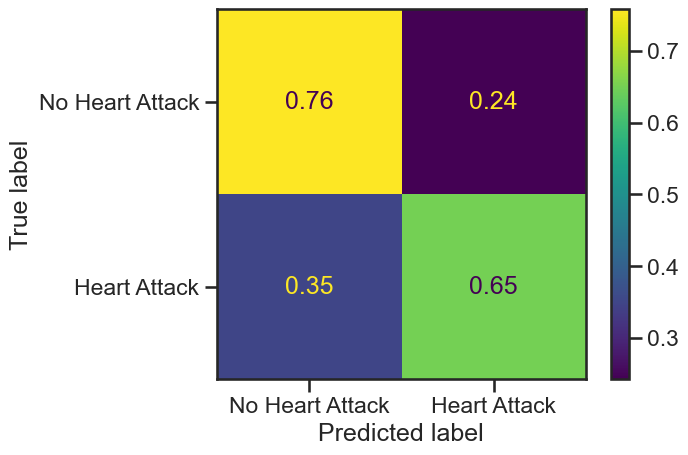

In [53]:
cm_rf=confusion_matrix(y_test, predictions_rf, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf,display_labels=['No Heart Attack','Heart Attack'])
disp.plot()
plt.show()

## Gradient Boosting 

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
210 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
206 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\P

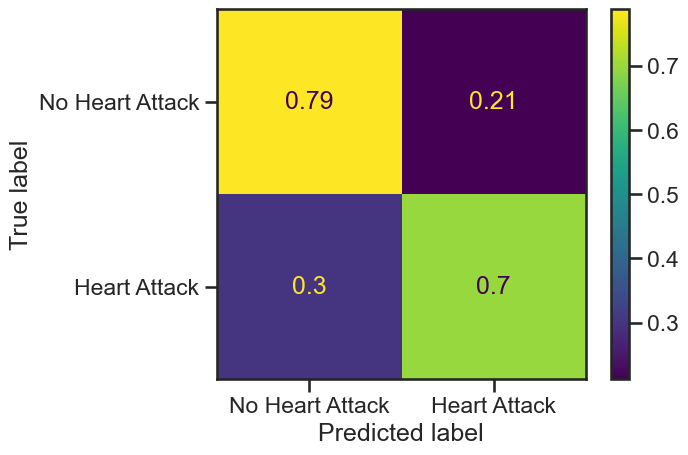

In [54]:
# The parameters to be fit
param_grid_gb = {
    'n_estimators': [5, 15, 25, 50, 100, 200, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 1.0],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}


# The grid search object
model_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid_gb, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
model_gb= model_gb.fit(X_train, y_train)

# The best model
model_gb.best_estimator_

predictions_gb=model_gb.predict(X_test)

cm_gb=confusion_matrix(y_test, predictions_gb, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb,display_labels=['No Heart Attack','Heart Attack'])
disp.plot()
plt.show()

## staking

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
210 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
76 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Py

Fitting 5 folds for each of 50 candidates, totalling 250 fits


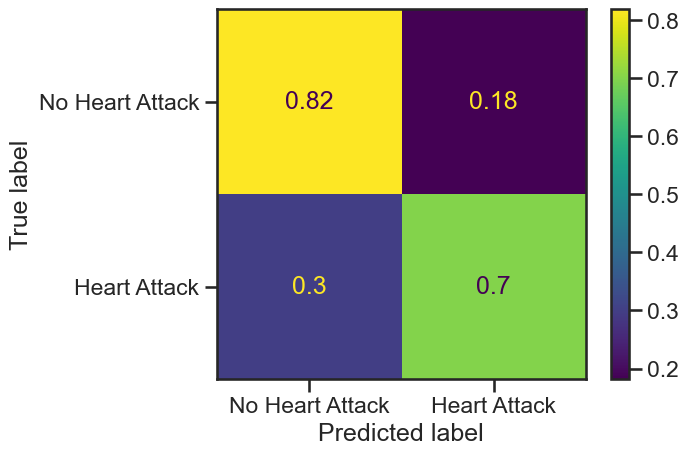

In [55]:
# The combined model--logistic regression and gradient boosted trees
estimators = [('LR', model_lr), ('KNN', knn), ('GB', model_gb), ('SVC', model_svm)]

# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='hard')
VC = VC.fit(X_train, y_train)

predictions_vc=VC.predict(X_test)

cm_vc=confusion_matrix(y_test, predictions_vc, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vc,display_labels=['No Heart Attack','Heart Attack'])
disp.plot()
plt.show()

## Metrics

In [57]:
metrics={}
metrics['Logistic Regression']=[accuracy_score(y_test, predictions_lr),precision_score(y_test, predictions_lr),
                           f1_score(y_test, predictions_lr), recall_score(y_test, predictions_lr)]
metrics['K-Nearest Neigbour']= [accuracy_score(y_test, predictions_knn),precision_score(y_test, predictions_knn),
                           f1_score(y_test, predictions_knn), recall_score(y_test, predictions_knn)]
metrics['Support Vector Machines']= [accuracy_score(y_test, predictions_lr),precision_score(y_test, predictions_lr),
                           f1_score(y_test, predictions_lr), recall_score(y_test, predictions_lr)]
# metrics['Decision Tree']= [accuracy_score(y_test, predictions_dt),precision_score(y_test, predictions_dt),
#                            f1_score(y_test, predictions_dt), recall_score(y_test, predictions_dt)]
metrics['Random Forest']= [accuracy_score(y_test, predictions_rf),precision_score(y_test, predictions_rf),
                           f1_score(y_test, predictions_rf), recall_score(y_test, predictions_rf)]
metrics['Gradient Boosting']= [accuracy_score(y_test, predictions_gb),precision_score(y_test, predictions_gb),
                           f1_score(y_test, predictions_gb), recall_score(y_test, predictions_gb)]
metrics['voting']= [accuracy_score(y_test, predictions_vc),precision_score(y_test, predictions_vc),
                           f1_score(y_test, predictions_vc), recall_score(y_test, predictions_vc)]


df=pd.DataFrame(metrics).T. rename(columns={0:'Accuracy', 1:'Precision', 2:'F', 3:'Recall'})
#df.to_csv(r'C:\Users\HP\Desktop\metrics.csv')
df


## Model Explanation

Text(0.5, 1.0, 'Permutation Importance')

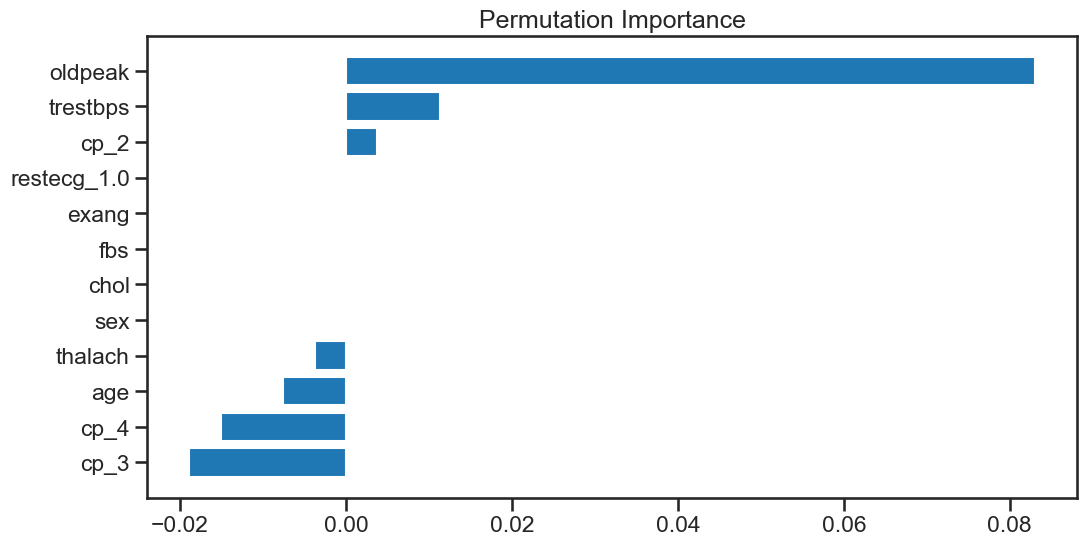

In [77]:
## Feature Permutation Importance
perm_importance = permutation_importance(knn, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')



Text(0.5, 1.0, 'Absolute Permutation Importance')

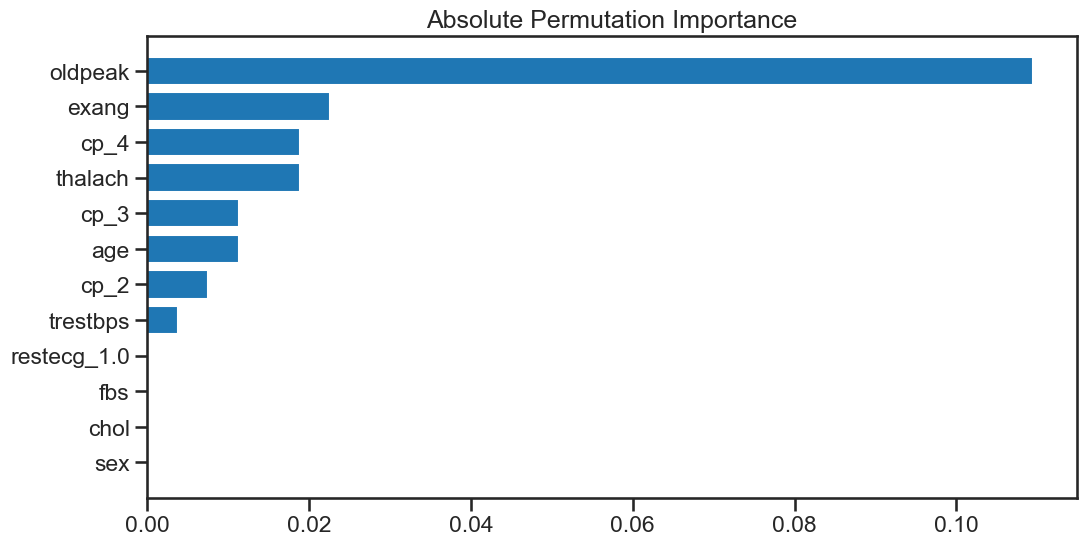

In [120]:
## Absolute Permutation Importance mean values
perm_importance = permutation_importance(knn, X_test, y_test)
sorted_idx = np.abs(perm_importance.importances_mean).argsort()  # Sort by absolute values
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), np.abs(perm_importance.importances_mean[sorted_idx]), align='center')  # Use np.abs() here
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Absolute Permutation Importance')


In [121]:
## Tabular form for Permutation Importance

perm_importance = permutation_importance(knn, X_test, y_test)
sorted_idx = np.abs(perm_importance.importances_mean).argsort()[::-1]  # Sort by absolute values in descending order

# Create a DataFrame to display the results
perm_imp_tbl = pd.DataFrame({
    'Feature': np.array(X_test.columns)[sorted_idx],
    'Absolute Permutation Importance': np.abs(perm_importance.importances_mean[sorted_idx])
})

# Print the DataFrame
perm_imp_tbl

perm_imp_tbl['Feature_label']=perm_imp_tbl['Feature'].apply(lambda x: feature_labels[x])  # get feature labels
perm_imp_tbl



,Feature,Absolute Permutation Importance,Feature_label
0,oldpeak,0.113208,ST depression induced by exercise relative to ...
1,cp_3,0.026415,chest pain: non-anginal pain
2,cp_4,0.018868,chest pain: asymptomatic
3,trestbps,0.015094,resting blood pressure
4,thalach,0.011321,maximum heart rate achieved
5,cp_2,0.007547,chest pain: atypical angina
6,exang,0.007547,exercise-induced angina
7,chol,0.007547,serum cholesterol
8,age,0.003774,age
9,restecg_1.0,0.000000,resting electrocardiographic results:having ST...


In [130]:
## Top four risk factors for heart attack
for i in list(perm_imp_tbl.head(5)['Feature_label'].unique()):
    print(i)

ST depression induced by exercise relative to rest
chest pain: non-anginal pain
chest pain: asymptomatic
resting blood pressure
maximum heart rate achieved


## Interactivity: Take user inputs and make predictions

In [ ]:
sex_lable={'Male': "1", 'Female':"0"}
exang_lable={'Yes': "1", 'No':"0"}
fbs_lable={'True':'1', 'False':'0'}
@interact
def predictions(sex=list(sex_lable.keys()),
                Exercise_induced_angina=list(exang_lable.keys()),
                High_fbs=list(fbs_lable.keys()),
                age=widgets.IntSlider(min=0, max=200, step=1, value=0),
                resting_BP = widgets.FloatText(value=0.0),
                Cholesterol = widgets.FloatText(value=0.0),
                Max_Heart_Rate = widgets.FloatText(value=0.0),
                ST_Depression = widgets.FloatText(value=0.0),
                Moderate_restecg=list(X['restecg_1.0'].unique()),
                High_restecg=list(X['restecg_2.0'].unique()),
                Chest_pains_atypical_angina=list(X['cp_2'].unique()),
                Chest_pains_non_anginal_pain=list(X['cp_3'].unique()),
                Chest_pains_asymptomatic=list(X['cp_4'].unique())):
    sex_dummy=int(sex_lable[sex])
    exang_dummy=int(exang_lable[Exercise_induced_angina])
    fbs_dummy=int(fbs_lable[High_fbs])
    user_inputs=[age, sex_dummy, resting_BP, Cholesterol, fbs_dummy, Max_Heart_Rate, exang_dummy, 
                 ST_Depression, Chest_pains_atypical_angina, Chest_pains_non_anginal_pain, Chest_pains_asymptomatic, 
                 Moderate_restecg, High_restecg]
    user_inputs_array=np.array(user_inputs)
    user_inputs_reshaped=user_inputs_array.reshape(1, -1)
    heart_attack=knn.predict(np.array(user_inputs_reshaped))[0]
    if heart_attack==0:
        heart_attack="HEART ATTACK"
    else:
        heart_attack = "NO HEART ATTACK"
    print()
    print("PREDICTION: {}".format(heart_attack))
    print("PRECISION SCORE: {}%".format(round(precision_score(y_test, predictions_knn),2)))
    
    
    #return user_inputs
     

interactive(children=(Dropdown(description='sex', options=('Male', 'Female'), value='Male'), Dropdown(descript…

In [131]:
data['heart_attack'].value_counts()

heart_attack
0    163
1     98
Name: count, dtype: int64

In [ ]:
# age: age in years
# sex: sex (1 = male; 0 = female)
# cp: chest pain type
# – 1: typical angina
# – 2: atypical angina
# – 3: non-anginal pain
# – 4: asymptomatic
# trestbps: resting blood pressure (in mm Hg on admission to the hospital)
# chol: serum cholesterol in mg/dl
# fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
# restecg: resting electrocardiographic results
# – 0: normal
# – 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
# – 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
# thalach: maximum heart rate achieved
# exang: exercise-induced angina (1 = yes; 0 = no)
# oldpeak: ST depression induced by exercise relative to rest
